# Hate Speech with LLM

This is practical exercise to see how LLM models like Ollama can help us to solve classification problems. I will be using two datasets and use prompt engineering to evalaute first the model without any fine-tunning. Then I will fine-tune the model and then I will compare the results.

In [1]:
### Loading helpful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

## Load the Hate Speech Data 1

In [2]:
### Loading the dataset
hate_speech_1 = pd.read_csv('data/hate-speech-data-1.csv')

In [3]:
### Exploring the dataset
hate_speech_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
### Checking a few records of the dataset
hate_speech_1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Identifying the important features

- tweet: The text which might contain a hateful content
- class: 
    - 0: Hate content
    - 1: Offensive
    - 2: Neighter or normal content

## Cleaning a bit this dataset

In [5]:
### Dropping unnecessary columns
hate_speech_1.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)
hate_speech_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [6]:
### Checking null values
hate_speech_1.isnull().sum()

class    0
tweet    0
dtype: int64

In [7]:
### Checking if there are empty tweets
hate_speech_1[hate_speech_1['tweet'] == '']

,class,tweet


In [8]:
### Fixing the class to match the following pattern: 0 = not hate speech, 1 = hate speech
hate_speech_1['class'] = hate_speech_1['class'].apply(lambda label: 0 if label == 2 else 1 )

## Load the Hate Speech Data 2

In [9]:
### Loading the dataset
hate_speech_2 = pd.read_csv('data/hate-speech-data-2.csv')

In [10]:
### Exploring the dataset
hate_speech_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [11]:
### Checking a few records of the dataset
hate_speech_2.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


## Identifying the important features

- content: The text which might contain a hateful content
- label: 
    - 0: Normal content
    - 1: Offensive or hateful

## Cleaning a bit this dataset

In [12]:
### Checking null values
hate_speech_2.isnull().sum()

Content    0
Label      0
dtype: int64

In [13]:
### Checking if there are empty Contents
hate_speech_2[hate_speech_2['Content'] == '']

,Content,Label


# EDA Analisys

## 1. Checking label distribution

In [14]:
### Checking the actual distribution of the classes
hate_speech_1['class'].value_counts()

class
1    20620
0     4163
Name: count, dtype: int64

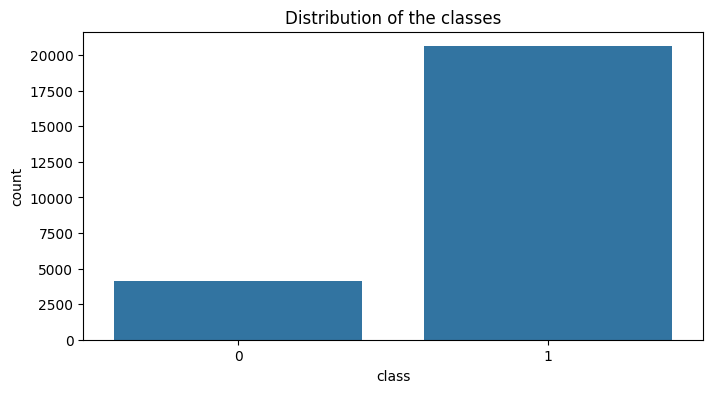

In [15]:
### Plotting the distribution of the classes using barplot
plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=hate_speech_1)
plt.title('Distribution of the classes')
plt.show()

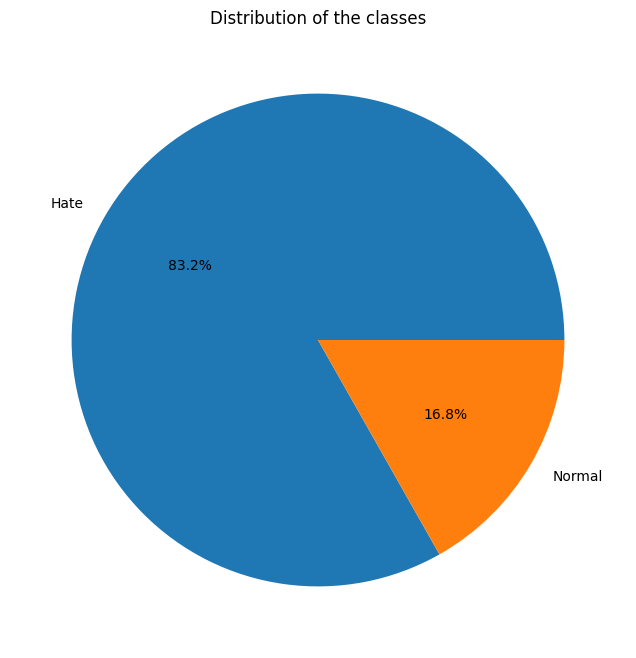

In [16]:
### Plotting the distribution of the classes using pie chart
plt.figure(figsize=(8, 8))
plt.pie(hate_speech_1['class'].value_counts(), labels=["Hate", "Normal"], autopct='%1.1f%%')
plt.title('Distribution of the classes')
plt.show()

## 2. Checking the text word count metrics

In [17]:
### Creating extra feature to count the number of words in each tweet
hate_speech_1['tweet_word_count'] = hate_speech_1['tweet'].apply(lambda x: len(x.split()))
hate_speech_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   class             24783 non-null  int64 
 1   tweet             24783 non-null  object
 2   tweet_word_count  24783 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 581.0+ KB


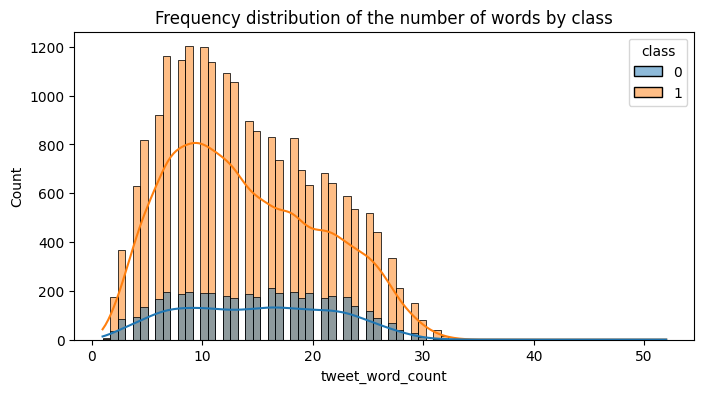

In [18]:
### Plotting the frequency distribution of the number of words by class
plt.figure(figsize=(8, 4))
sns.histplot(data=hate_speech_1, x='tweet_word_count', hue='class', kde=True)
plt.title('Frequency distribution of the number of words by class')
plt.show()

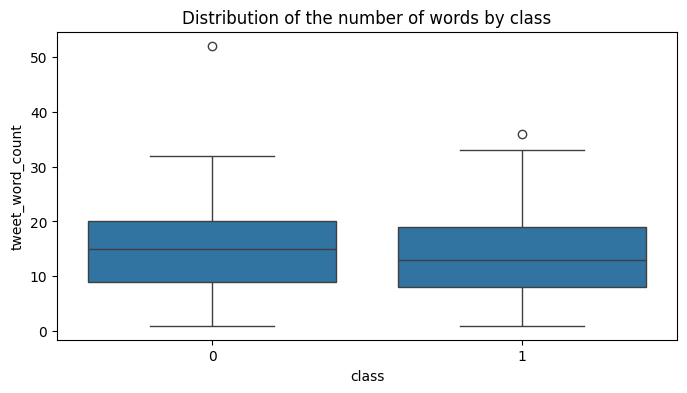

In [19]:
### Checking the distribution of the number of words by class using boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='class', y='tweet_word_count', data=hate_speech_1)
plt.title('Distribution of the number of words by class')
plt.show()

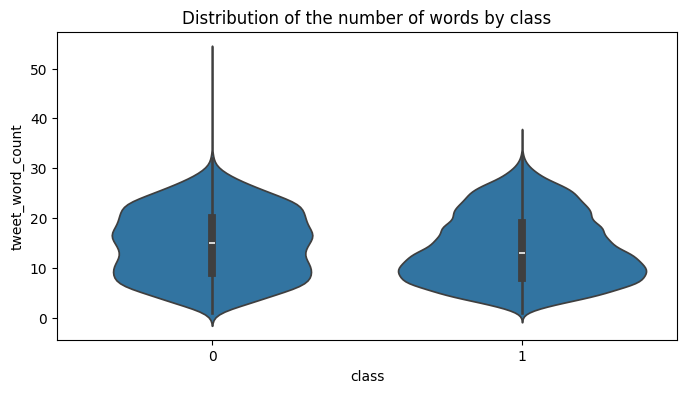

In [20]:
### Checking the distribution of the number of words by class using violinplot
plt.figure(figsize=(8, 4))
sns.violinplot(x='class', y='tweet_word_count', data=hate_speech_1)
plt.title('Distribution of the number of words by class')
plt.show()

## 3. Generating wordcloud between texts with hate content and ones without it

In [21]:
### Downloading nltk dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diegoagd10/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoagd10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diegoagd10/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
### Splitting the texts by hate speech and normal
hate_speech = hate_speech_1[hate_speech_1['class'] == 1]['tweet']
normal = hate_speech_1[hate_speech_1['class'] == 0]['tweet']

In [23]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords.words("english")).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

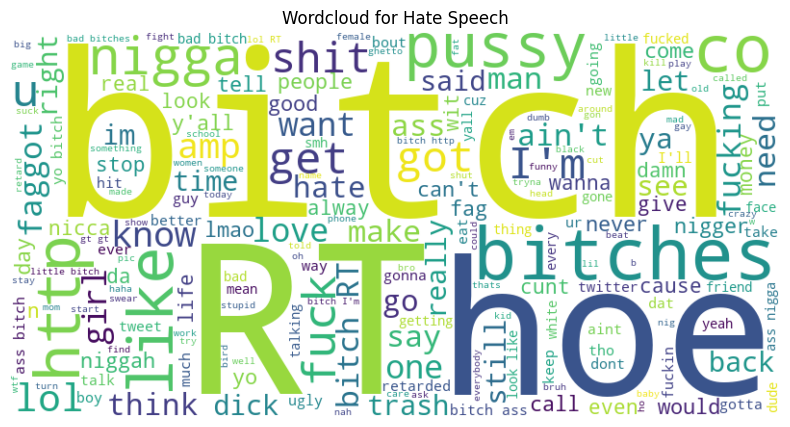

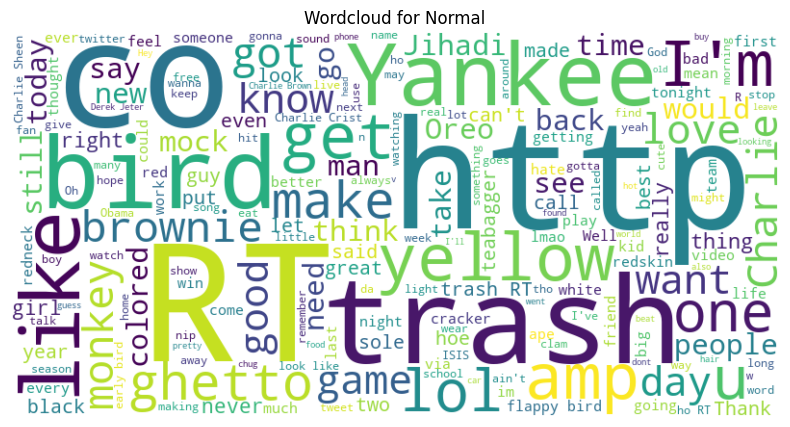

In [24]:
### Generating wordclouds
generate_wordcloud(hate_speech, 'Wordcloud for Hate Speech')
generate_wordcloud(normal, 'Wordcloud for Normal')

## Observations

1. I'm dealing with an imbalanced dataset, so I might need to reduce the number of hate values randomly

2. Shorter texts tend to be hateful.

3. The word cloud for hateful content highligth bad words.

# Text preprocesing

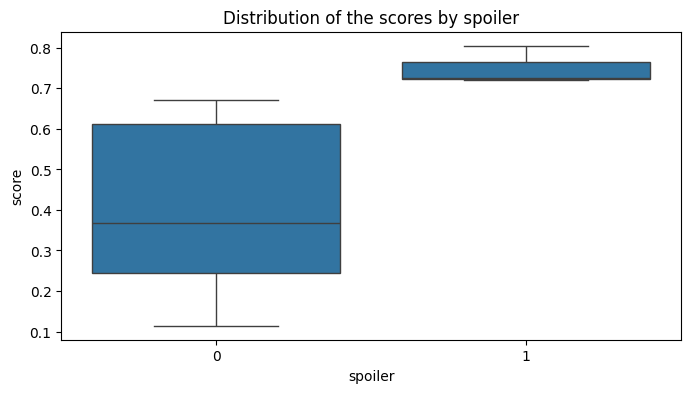

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')

synopsis = """The film opens with John (Brad Pitt) and Jane Smith (Angelina Jolie) answering questions during marriage counseling. The couple has been married for "five or six" years, but their marriage is suffering to the point that they cannot remember the last time they had sex. They tell the story of their first meeting in Bogotá, Colombia, where they met while both were secretly on the run from Colombian authorities. They quickly fell in love and were married. John later states that Jane "looked like Christmas morning" to him on the day they met.In reality, John and Jane are both skilled assassins working for different firms, both among the best in their field, but both with very different methods of assassination, with Jane working out thorough plans and John taking a less analytical approach. Each is concealing their true profession from their spouse. Under these cover stories, John and Jane balance their apparently mundane marriage which both of them find after a few years to be growing dull and suffocating with their secretive work. When both are assigned to kill Benjamin "The Tank" Danz (Adam Brody), they encounter each other on the job and botch the hit. Believing each had been sent to stop the other from completing their mission, they seek to discover and eliminate the other.After a few "mild" attempts on each other\'s lives, fueled by a mutual sense of betrayal, the marital spat culminates in a high-octane fight in the Smith house. After a long, evenly-matched fight, with their house shot to shambles, they wind up with guns in each other\'s faces. John balks, and lays his gun down; Jane finds she cannot shoot her spouse either, and both succumb to their love instead. Mr. and Mrs. Smith reunite and rediscover each other.The newly-rekindled Smith partnership is quickly threatened by their employers, who have now decided to eliminate the couple. John\'s best friend and coworker, Eddie (Vince Vaughn), turns down a bounty of $400,000 for each Smith, but John and Jane find themselves under fire from an army of assassins. Fending off an attack which blows up their house, the Smiths steal their neighbor\'s minivan and successfully destroy three pursuing armored cars of attackers, all while bickering over their fighting styles and newly-discovered personal secrets.After meeting with Eddie, the Smiths decide to fight together to preserve their marriage. They kidnap Danz from his high-security prison in order to give their employers something they want more than the Smiths. Danz reveals that he was merely bait, hired jointly by their employers after it was discovered that the Smiths were married, in the hopes of having one Smith kill the other. Danz also wears a cameo Fight Club t-shirt, referencing to Brad Pitt\'s previous movie of the same name.John and Jane forgo their separate contingency plans and make their stand together. In the final fight scene of the film, the Smiths now working smoothly together as a team defeat an extended attack by a large number of armed forces during a long shoot-out inside a department store.The film ends with the couple meeting the marriage counselor again, where the Smiths state how much their marriage has thrived and how happy they really are."""

reviews_without_spoilers = [
    "Good movie, I liked it.",
    "I didn't like the ending, but the rest was good.",
    "I love the story explained in the movie.",
    "Mr. & Mrs. Smith is a great movie.",
    """Doug Liman's "Mr. & Mrs. Smith" delivers a perfect blend of action and romantic comedy, with Brad Pitt and Angelina Jolie's electric chemistry lighting up every scene. The film cleverly uses the metaphor of marriage counseling to explore the complexities of modern relationships, while simultaneously serving up expertly choreographed action sequences. The balance between domestic drama and high-stakes espionage creates a unique viewing experience that keeps audiences guessing. While some plot points stretch credibility, the charismatic leads make every moment believable through their exceptional performances.""",
    """From its opening scenes in Colombia to its explosive finale, "Mr. & Mrs. Smith" maintains a breakneck pace while never losing sight of its emotional core. The film's greatest strength lies in its ability to make mundane married life as engaging as its spectacular action sequences. Pitt and Jolie bring both humor and depth to their roles, creating characters that feel both larger than life and remarkably human. The supporting cast, particularly Vince Vaughn, provides excellent comic relief that helps balance the film's more intense moments.""",
    """Director Doug Liman has crafted a sophisticated action-romance that transcends both genres. The film's production design deserves special mention, with every setting perfectly calibrated to enhance both the action and the story's themes. While the plot occasionally takes convenient turns, the movie's style and wit make it easy to overlook these minor flaws. The cinematography and action choreography are top-notch, creating sequences that are both visually stunning and emotionally resonant."""
]

reviews_with_spoilers = [
    """The brilliant twist of "Mr. & Mrs. Smith" isn't just that both spouses are assassins – it's how the film uses this revelation to explore trust and communication in relationships. The moment when John and Jane discover each other's true identities leads to one of cinema's most memorable domestic disputes, culminating in a house-destroying fight sequence that serves as a perfect metaphor for marital discord. The film's conclusion, where the couple must unite against their employers, cleverly suggests that the real threat to marriage isn't internal conflict but external pressures.""",
    """Starting with a deceptively simple meet-cute in Bogotá, the film builds to a complex exploration of marriage through the lens of professional killers. The revelation that Benjamin Danz was merely bait, designed to pit the Smiths against each other, adds a clever layer to the plot. The film's final act, set in a department store, shows how the couple's individual skills complement each other perfectly when they finally work as a team. Their return to marriage counseling at the end, now honest about their violent profession, provides a satisfying bookend to their story.""",
    """The genius of "Mr. & Mrs. Smith" lies in how it uses the assassin premise to explore marital deception. The transition from their initial attempts to kill each other to their eventual reconciliation feels earned, particularly in the pivotal moment when John lays down his gun first. The film's clever use of action sequences to represent relationship dynamics reaches its peak in the final department store battle, where their newly honest partnership makes them an unstoppable team. The subtle reference to "Fight Club" through Danz's t-shirt adds an extra layer of meta-commentary to a film already rich in subtext."""
]


encoding1 = model.encode(synopsis)

scores = []

for review in reviews_without_spoilers:
    encoding2 = model.encode(review)
    similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
    scores.append(similarity)

for review in reviews_with_spoilers:
    encoding2 = model.encode(review)
    similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
    scores.append(similarity)


### Use the above reviews to create a pandas DataFrame where we have columns text, score, and spoiler
reviews = reviews_without_spoilers + reviews_with_spoilers
spoilers = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

df = pd.DataFrame({'text': reviews, 'score': scores, 'spoiler': spoilers})
df

### Plotting boxplot to show the distribution of the scores by spoiler
plt.figure(figsize=(8, 4))
sns.boxplot(x='spoiler', y='score', data=df)
plt.title('Distribution of the scores by spoiler')
plt.show()

# Working with the LLM

In [25]:
### Loading LLM model
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-7B")
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-7B")

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [28]:
text = "Que es el cielo?"
input_ids = tokenizer.encode(text, return_tensors="pt")

T = 10
outputs = model.generate(input_ids, max_new_tokens = T)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


KeyboardInterrupt: 